# Bone Cancer
## Question of Interest

The aim of this project is to build a model that can predict the location of cancer based on the genetic data of the patient: in particular, whether it is present in bone tissue.

## Preparing the Data
### Importing the Data

In [1]:
import icgc
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parse the JSON string into a Python list
data_list = json.loads(
    icgc.query(request_type="donors",pql='select(id,primarySite),limit(1000000)')
)
df = pd.DataFrame(data_list)

### Inspecting the Data

In [2]:
df["primarySite"].value_counts()

primarySite
Blood             3186
Brain             2504
Breast            1970
Liver             1840
Kidney            1551
Head and neck     1505
Prostate          1419
Lung              1200
Stomach           1173
Nervous System    1105
Pancreas          1072
Colorectal        1041
Esophagus          877
Skin               753
Ovary              727
Uterus             565
Bladder            515
Bone               341
Gall Bladder       310
Mesenchymal        307
Cervix             307
Nasopharynx         21
Name: count, dtype: int64

In [3]:
donorIDs_boneCancer = df["id"][df["primarySite"] == "Bone"].to_list()
donorIDs_otherCancer = df["id"][df["primarySite"] != "Bone"].to_list()
all_donors = df["id"]

### Retrieving mutation data for DNA donors

In [4]:
# in() function does not appear to work the same way as eq(), and no information is available online on how to use it
# therefore, a loop will be required
data_list = json.loads(
    icgc.query(request_type="occurrences",pql='select(donorId,mutationId),eq(donorId,"' + donorIDs_boneCancer[0] + '"),limit(10000000)')
)
df_occurrences = pd.DataFrame(data_list)
df_occurrences = df_occurrences.drop(['genes','observations'], axis=1)

for donor_id in tuple(donorIDs_boneCancer[1:]):
    # Code to be executed for each element
    # Get the occurrences
    data_list = json.loads(
        icgc.query(request_type="occurrences",pql='select(donorId,mutationId),eq(donorId,"' + donor_id + '"),limit(10000000)')
    )
    df_occurrences_iteration = pd.DataFrame(data_list)
    try:
        df_occurrences_iteration = df_occurrences_iteration.drop(['genes','observations'], axis=1)
        df_occurrences = df_occurrences.merge(df_occurrences_iteration,how='outer')
    except:
        if (df_occurrences_iteration.size > 0):
            raise Exception('Error merging results. Some rows missed.')
    #df_occurrences
df_occurrences
#df_indexed = df.set_index('id')
#df_indexed

,donorId,mutationId
0,DO52613,MU92544784
1,DO52613,MU92459802
2,DO52613,MU92245768
3,DO52613,MU92215581
4,DO52613,MU92253091
...,...,...
248767,DO994,MU197
248768,DO944,MU2188404
248769,DO50479,MU28809201
248770,DO967,MU1385


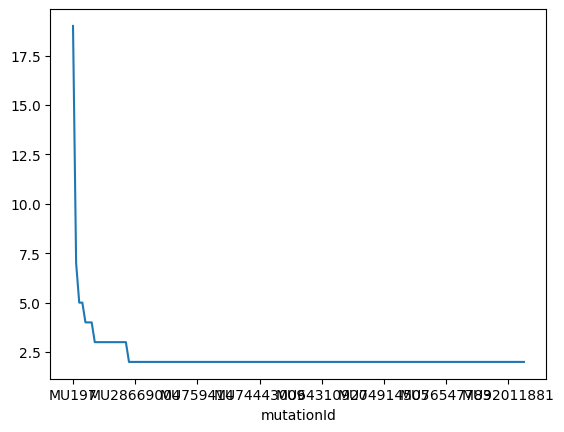

In [5]:
(df_occurrences["mutationId"].value_counts()[(df_occurrences["mutationId"].value_counts() >= 2)]).plot();

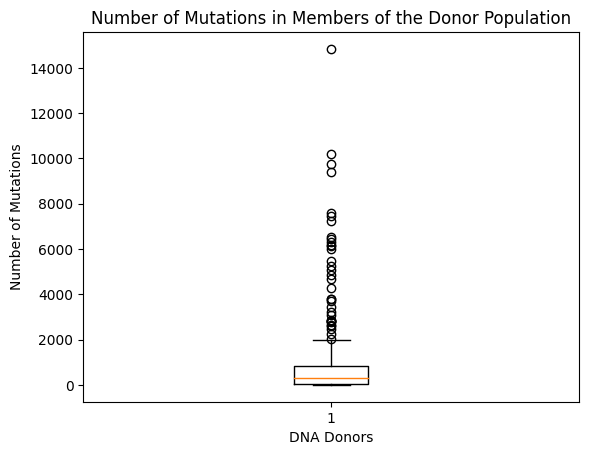

In [6]:
# ; suppresses unwanted text output
plt.boxplot(df_occurrences["donorId"].value_counts());
plt.xlabel("DNA Donors")
plt.ylabel("Number of Mutations")
plt.title("Number of Mutations in Members of the Donor Population");

In [7]:
mutations_of_interest = (df_occurrences["mutationId"].value_counts()[(df_occurrences["mutationId"].value_counts() >= 2)].index)
len(mutations_of_interest)

146

I'd like a boxplot for the below

In [8]:
data = pd.DataFrame(np.zeros([len(all_donors),len(mutations_of_interest.tolist())+2]),columns=["donorId"]+["Target"]+mutations_of_interest.tolist())
data["donorId"] = all_donors
data["Target"] = (df["primarySite"] == "Bone").astype(int)
for mutation in mutations_of_interest:
    data_list = json.loads(
        icgc.query(request_type="occurrences",pql='select(donorId,mutationId),eq(mutationId,"' + mutation + '"),limit(100000)')
    )
    data[mutation] = [1 if item in pd.DataFrame(data_list)["donorId"].tolist() else 0 for item in all_donors]
data

,donorId,Target,MU197,MU99,MU272,MU74368039,MU23138892,MU91706760,MU28547779,MU885,...,MU75059795,MU92469482,MU91979135,MU28725954,MU92011881,MU75038996,MU28472843,MU91827587,MU30679646,MU921
0,DO232761,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DO232224,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,DO222843,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,DO222837,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,DO50970,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24284,DO46091,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24285,DO231055,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24286,DO46275,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24287,DO45647,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


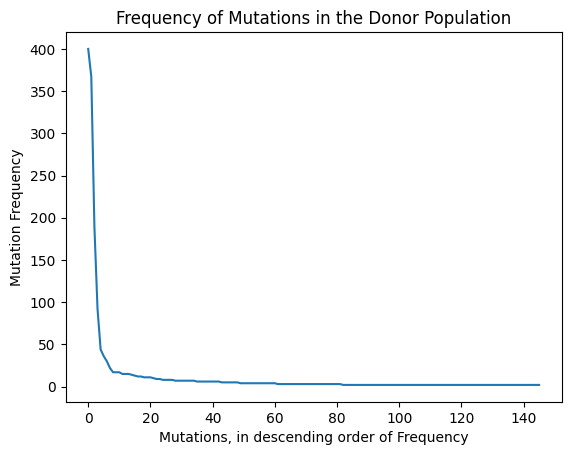

In [9]:
mutation_sums = []

for mutation in mutations_of_interest:
    mutation_sums.append(sum(data[mutation]))

mutation_sums.sort(reverse=True)

# ; suppresses unwanted text output
plt.plot(mutation_sums);
plt.xlabel("Mutations, in descending order of Frequency")
plt.ylabel("Mutation Frequency")
plt.title("Frequency of Mutations in the Donor Population");

Note that the number of mutations that only appear once in the population of bone cancer sufferers is far larger than the number that appear at least twice

## Creating a machine learning model
### Setting up the model

In [10]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=150, min_samples_split=2000, random_state=1)

In [11]:
import random

Target1Samples = random.sample(list(range(sum(data['Target']))),k=171)
Target0Samples = random.sample(list(range(len(data[data['Target'] == 0]))),k=13000)

Target1Samples_inverse = list(set(range((sum(data['Target'])))) - set(Target1Samples))
Target0Samples_inverse = list(set(range(len(data[data['Target'] == 0]))) - set(Target1Samples))

data.iloc[Target1Samples+Target0Samples]


,donorId,Target,MU197,MU99,MU272,MU74368039,MU23138892,MU91706760,MU28547779,MU885,...,MU75059795,MU92469482,MU91979135,MU28725954,MU92011881,MU75038996,MU28472843,MU91827587,MU30679646,MU921
314,DO229230,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
160,DO229005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
310,DO229297,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,DO41020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
268,DO223732,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13747,DO2545,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14078,DO11435,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,DO220891,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
887,DO224982,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Create a train and test set
train = data.iloc[Target1Samples+Target0Samples]
test = data.iloc[Target1Samples_inverse+Target0Samples_inverse]

model.fit(train[mutations_of_interest], train["Target"])

RandomForestClassifier(min_samples_split=2000, n_estimators=150, random_state=1)

### Testing the model

In [13]:
# Evaluate accuracy of predictions
preds = model.predict(test[mutations_of_interest])
preds = pd.Series(preds, index=test.index)
print('There were', sum(preds[preds == 1] == test['Target'][preds == 1]), 'True Positives,', sum(preds[preds == 1] != test['Target'][preds == 1]), 'False Positives,', sum(preds[preds == 0] == test['Target'][preds == 0]), 'True Negatives, and', sum(preds[preds == 0] != test['Target'][preds == 0]), 'False Negatives')

There were 56 True Positives, 11 False Positives, 23601 True Negatives, and 279 False Negatives


In [14]:
# Model has too many False Negatives: attempting to develop an alternative
preds = model.predict_proba(test[mutations_of_interest])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .4] = 1
preds[preds <= .4] = 0
print('Correctly predicted', sum(preds==test["Target"]),  '/', len(preds), '(', round(100*sum(preds==test["Target"])/len(preds),1) ,'% )' ', of which', sum(preds == 1), 'were identified as bone cancer patients.')
print('There were', sum(preds[preds == 1] == test['Target'][preds == 1]), 'True Positives,', sum(preds[preds == 1] != test['Target'][preds == 1]), 'False Positives,', sum(preds[preds == 0] == test['Target'][preds == 0]), 'True Negatives, and', sum(preds[preds == 0] != test['Target'][preds == 0]), 'False Negatives')

Correctly predicted 23657 / 23947 ( 98.8 % ), of which 89 were identified as bone cancer patients.
There were 67 True Positives, 22 False Positives, 23590 True Negatives, and 268 False Negatives


As the first model is more accurate, that is the one that will be used.